<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/RFMAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Install squarify for treemap plot
!pip install squarify

In [ ]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/onlineRetail

/content/drive/My Drive/Colab Notebooks/onlineRetail


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import squarify

%config InlineBackend.figure_format = 'retina'

In [ ]:
# Import data
df = pd.read_csv('onlineRetail.csv',
                 dtype = {'Invoice': str,
                          'StockCode': str,
                          'Description': str,
                          'Quantity': np.int64,
                          'Price': np.float64,
                          'Customer ID': str,
                          'Country': str},
                 parse_dates = ['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   object        
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
# Data cleansing
# Missing values
print(f'Total missing values on each column\n{df.isnull().sum()}')

Total missing values on each column
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


In [ ]:
# Remove missing 'Customer ID'
df = df[df['Customer ID'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   Price        824364 non-null  float64       
 6   Customer ID  824364 non-null  object        
 7   Country      824364 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 56.6+ MB


In [ ]:
# Negative 'Quantity' and 'Price' (less than 0)
print(f"Total 'Quantity' column less than 0: {np.sum(df['Quantity'] <= 0)} row")
print(f"Total 'Price' column less than 0: {np.sum(df['Price'] <= 0)} row")

Total 'Quantity' column less than 0: 18744 row
Total 'Price' column less than 0: 71 row


In [ ]:
# Remove negative 'Quantity' and 'Price'
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805549 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  int64         
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  object        
 7   Country      805549 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 55.3+ MB


In [ ]:
# Describe numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,805549.0,13.290522,143.634088,1.000,2.00,5.00,12.00,80995.0
Price,805549.0,3.206561,29.199173,0.001,1.25,1.95,3.75,10953.5


In [ ]:
# The maximum and minimum of 'Quantity' and 'Price' are too far
# Replace with quartile method
for col in ['Quantity', 'Price']:
  series = sorted(df[col])
  Q1, Q3 = np.quantile(series, [0.01, 0.99])
  IQR = Q3 - Q1
  lowerLimit = Q1 - (1.5 * IQR)
  upperLimit = Q3 + (1.5 * IQR)
  df[col] = np.where(df[col] < lowerLimit, lowerLimit, df[col])
  df[col] = np.where(df[col] > upperLimit, upperLimit, df[col])

In [ ]:
# Describe numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,805549.0,11.841087,26.828279,1.000,2.00,5.00,12.00,318.50
Price,805549.0,2.950138,3.238483,0.001,1.25,1.95,3.75,36.94


In [ ]:
# Calculate total price per invoice
df = df.eval("TotalPrice = Quantity * Price")
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [ ]:
# Fix date to recent period
df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x: x.replace(year = x.year + 9))
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2018-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2018-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2018-12-01 07:45:00,1.25,13085,United Kingdom,30.0


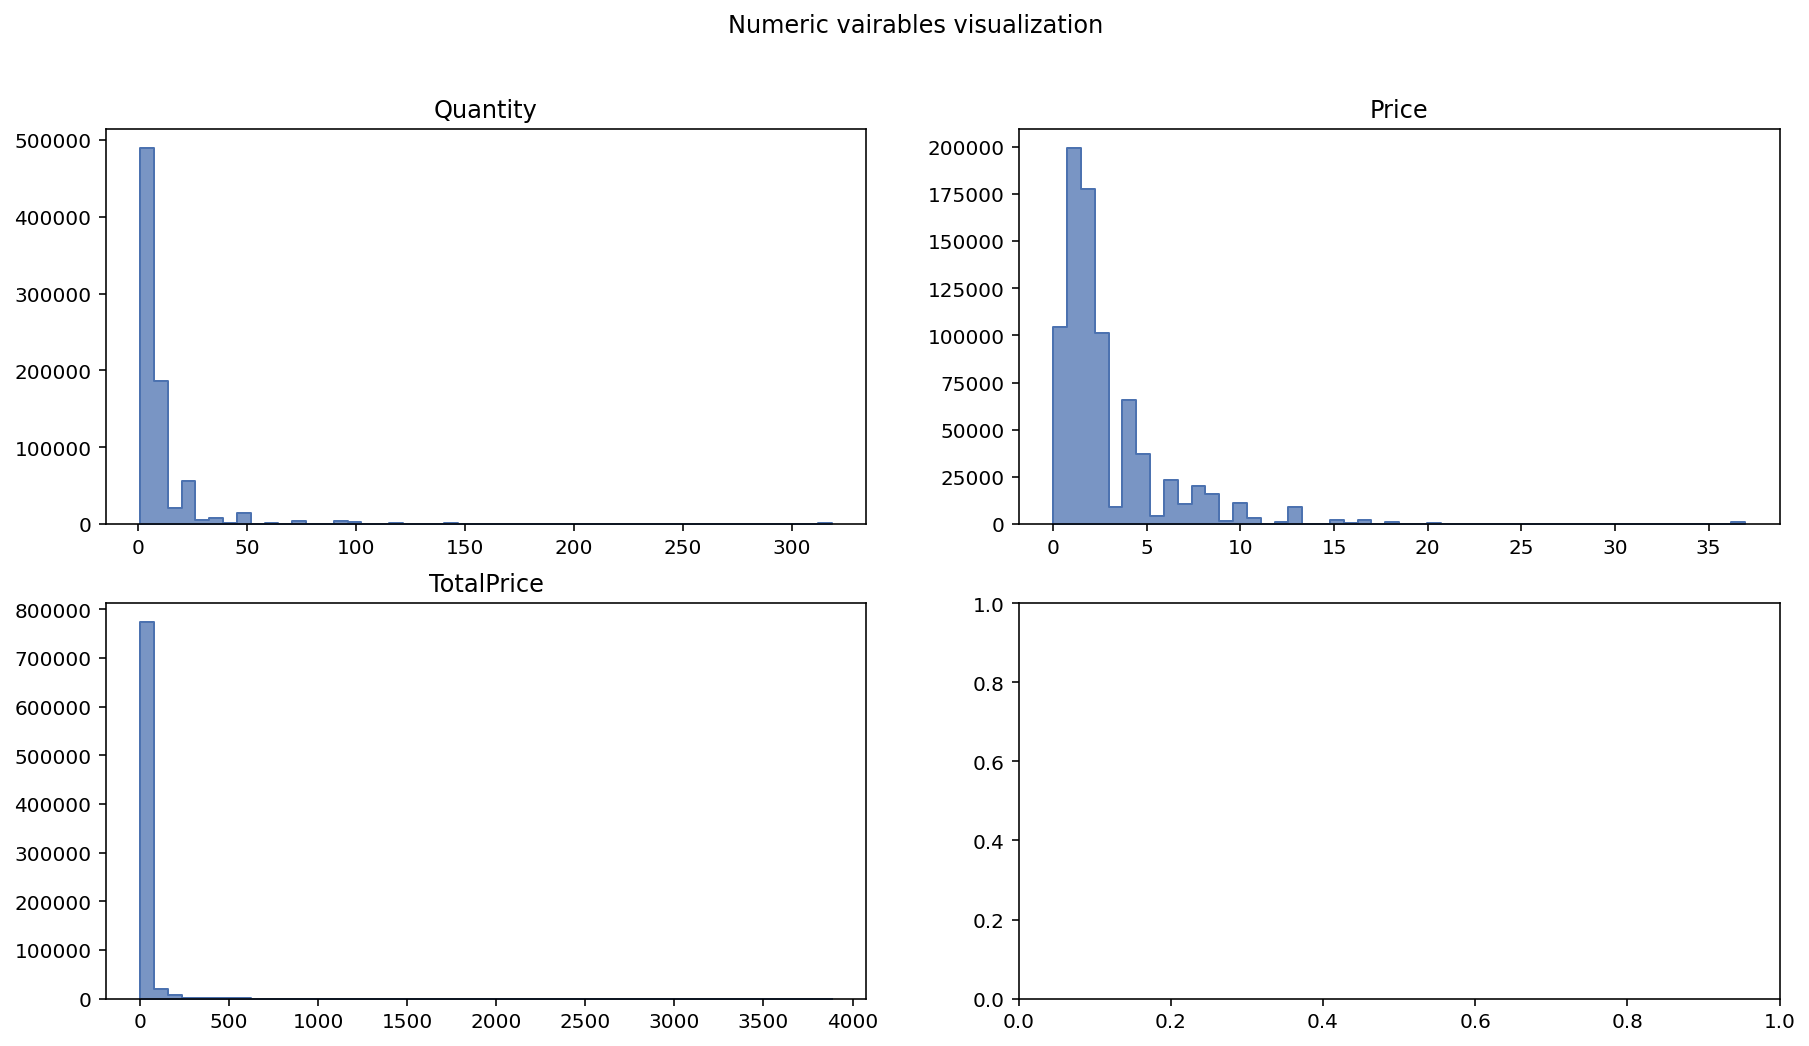

In [ ]:
# Histogram plot
with plt.style.context('seaborn-deep'):
  fig, axs = plt.subplots(2, 2, figsize = (15, 8))
  fig.suptitle('Numeric vairables visualization')
  axs = axs.ravel()
  for i, var in enumerate(df.select_dtypes(np.number).columns):
    sns.histplot(x = var,
              data = df,
              bins = 50,
              element = 'step',
              ax = axs[i])
    axs[i].set_title(f'{var}')
    axs[i].set(xlabel = '', ylabel = '')
plt.show()

In [ ]:
# Export cleaned data
df.to_csv('onlineRetailClean.csv', index = 0)

In [ ]:
# Data for model
fixDate = '30/06/2021'
fixDate = pd.Timestamp(fixDate) #Convert string to timestamp

dfRFM = df.groupby(['Customer ID']).agg(
    {
        'InvoiceDate': lambda date: (fixDate - date.max()).days,
        'Invoice': lambda num: num.nunique(),
        'TotalPrice': lambda price: price.sum()
    }
)

dfRFM.columns = ['Recency', 'Frequency', 'Monetary']
dfRFM.head(5)

,Recency,Frequency,Monetary
Customer ID,,,
12346,528,12,704.10
12347,204,8,5633.32
12348,277,5,1991.86
12349,220,4,3786.50
12350,513,1,331.34


##Customer segmentation by score
![RFM Analysis](https://www.everydaymarketing.co/wp-content/uploads/2021/04/Screen-Shot-2564-04-08-at-13.23.50.png)

In [ ]:
# Create binning for 5 bins
dfRFM['RecencyScore'] = pd.qcut(dfRFM['Recency'], 5, labels = [5, 4, 3, 2, 1])
dfRFM['FrequencyScore'] = pd.qcut(dfRFM['Frequency'].rank(method = 'first'),
                                  5, labels = [1, 2, 3, 4, 5])
dfRFM['MonetaryScore'] = pd.qcut(dfRFM['Monetary'], 5, labels = [5, 4, 3, 2, 1])
dfRFM.head(5)

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
Customer ID,,,,,,
12346,528,12,704.10,2,5,3
12347,204,8,5633.32,5,4,1
12348,277,5,1991.86,3,4,2
12349,220,4,3786.50,5,3,1
12350,513,1,331.34,2,1,4


In [ ]:
# RFM Score
dfRFM['RFMScore'] = dfRFM['RecencyScore'].astype(str) + dfRFM['FrequencyScore'].astype(str)
dfRFM.head(5)

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
Customer ID,,,,,,,
12346,528,12,704.10,2,5,3,25
12347,204,8,5633.32,5,4,1,54
12348,277,5,1991.86,3,4,2,34
12349,220,4,3786.50,5,3,1,53
12350,513,1,331.34,2,1,4,21


##RFM Score mapping table
![RFM Score](https://www.everydaymarketing.co/wp-content/uploads/2021/04/Screen-Shot-2564-04-08-at-13.45.27-1.png)

In [ ]:
# Convert RFM Score to segment label
RFMLabel = {
    r'55': "Champion",
    r'[3-5][4-5]': "Loyal",
    r'[4-5][2-3]': "Promising",
    r'51': "New Customers",
    r'41': "Warm Leads",
    r'31': "Cold Leads",
    r'[2-3][2-3]': "Need Attention",
    r'[1-2][5]': "Shouldn't Lost",
    r'[1-2][3-4]': 'Sleepers',
    r'[1-2][1-2]': "Lost"
}

dfRFM['Segment'] = dfRFM['RFMScore'].replace(RFMLabel, regex = True)
dfRFM.head(5)

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,Segment
Customer ID,,,,,,,,
12346,528,12,704.10,2,5,3,25,Shouldn't Lost
12347,204,8,5633.32,5,4,1,54,Loyal
12348,277,5,1991.86,3,4,2,34,Loyal
12349,220,4,3786.50,5,3,1,53,Promising
12350,513,1,331.34,2,1,4,21,Lost


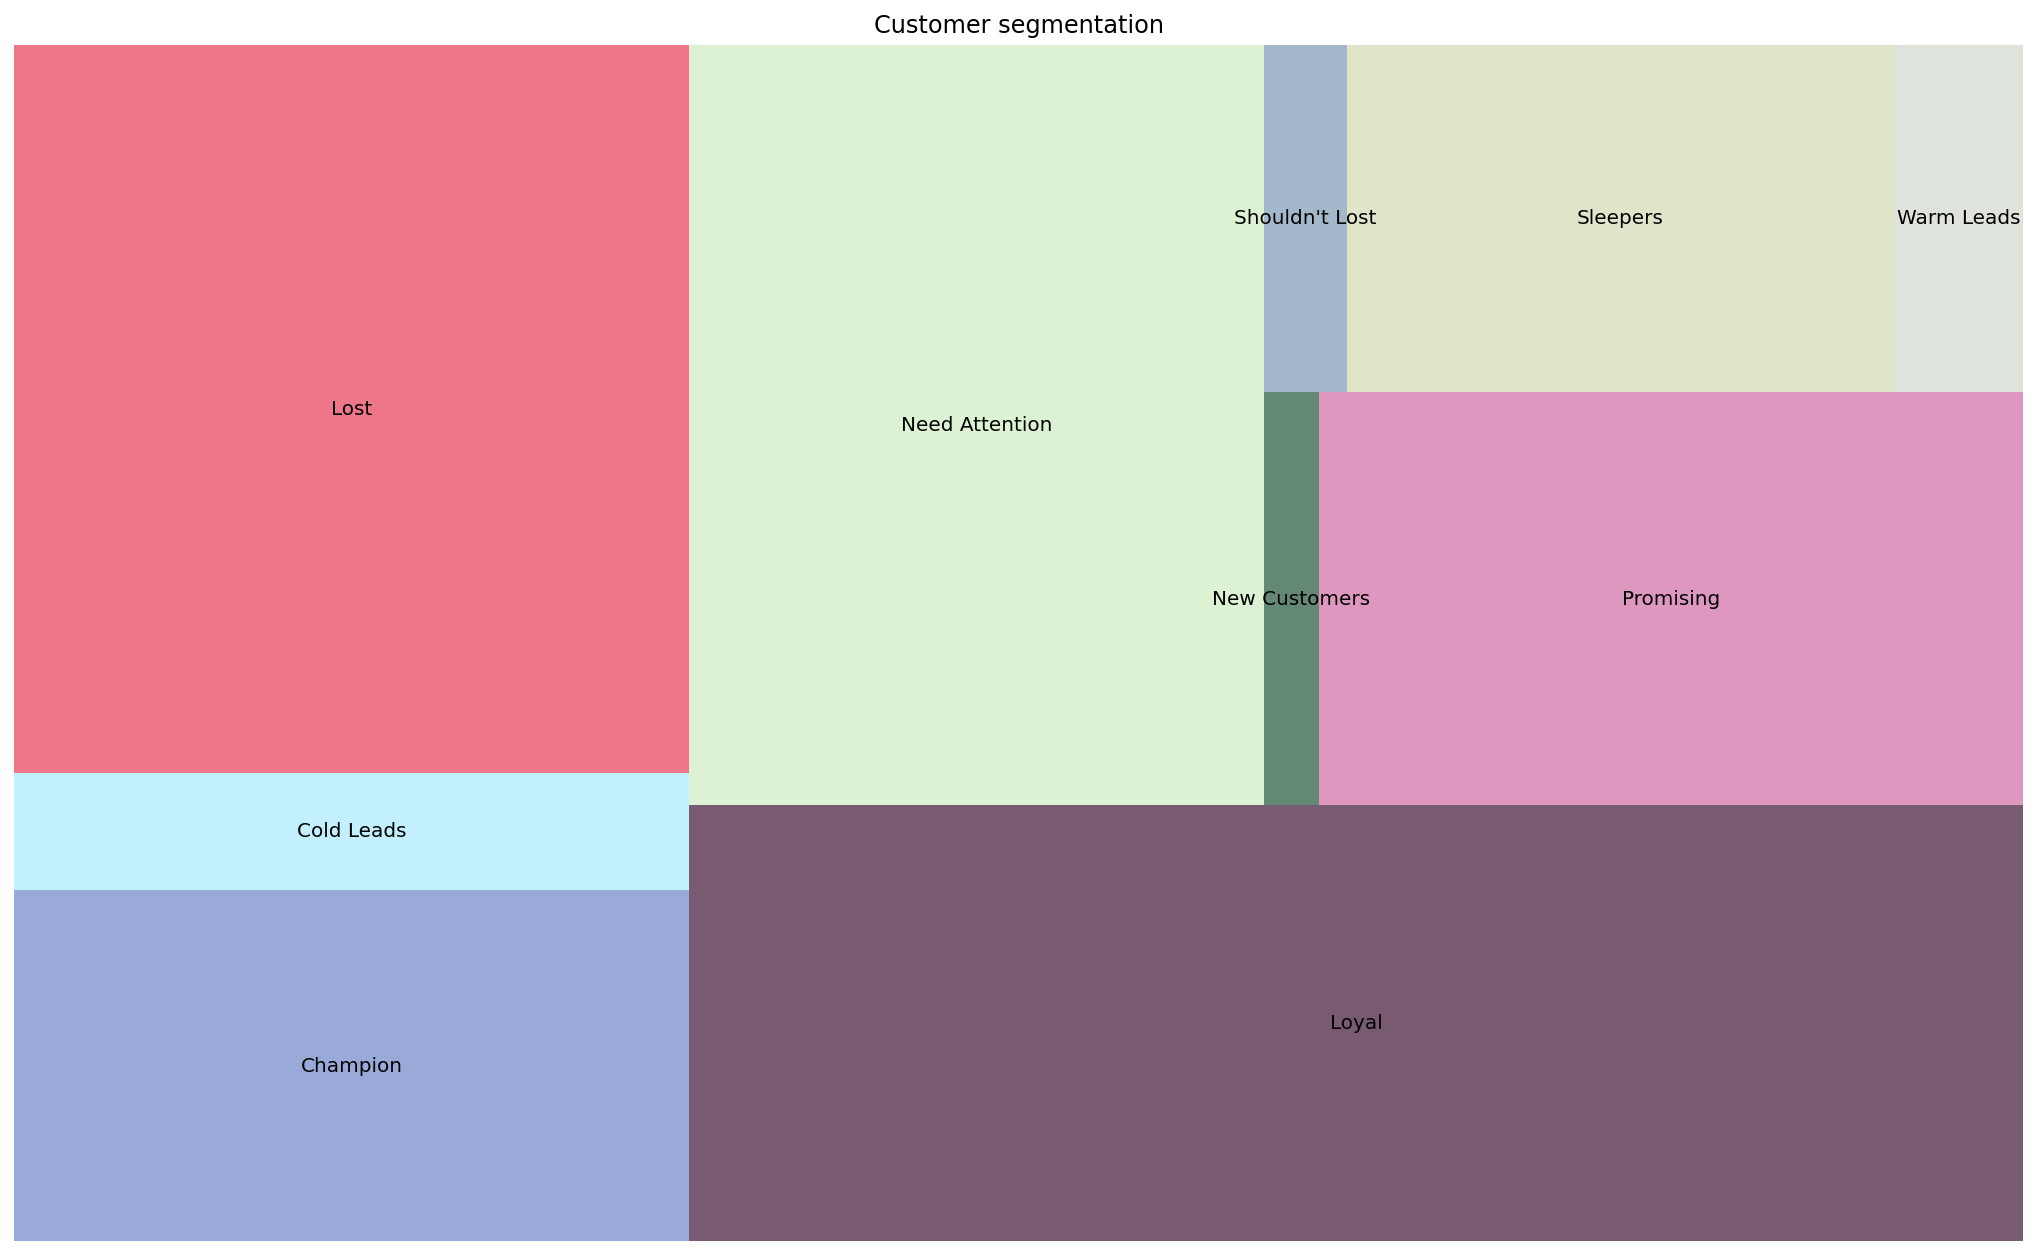

In [ ]:
# RFM Result
result = dfRFM.groupby(['Segment'])['Segment'].count()
values = list(result)
labels = result.index

# Plot
colors = [list(np.random.uniform(size = 4)) for i in range(len(values))]

plt.figure(figsize = (18, 11))
with plt.style.context('seaborn-deep'):
  squarify.plot(sizes = values, color = colors, label = labels)
  plt.axis('off')
  plt.title('Customer segmentation')
  plt.show()